In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import datetime
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Definitions

In [2]:
def plot_charger_timelines(df, zero_time, show_service=False, highlight=False, title_fmt='{}'):
    # Define relevant times
    t_start = zero_time + pd.to_timedelta(
        df['start_time'].min(), unit='minute') - datetime.timedelta(hours=1)
    t_end = zero_time + pd.to_timedelta(
        df['end_time'].max(), unit='minute') + datetime.timedelta(hours=1)
    t_srs = pd.date_range(
        t_start, t_end, freq='min').to_series()
    highlight_df = t_srs.between(
        datetime.datetime(2023, 12, 6, 7, 0),
        datetime.datetime(2023, 12, 6, 9, 0)).to_frame(
        name='peak')
    trip_col_labels = {
        'start_time': 'Start Time',
        'end_time': 'End Time',
        'delay': 'Delay'
    }
    
    df['Delayed'] = df['delay'] > 0
    df['Delayed'] = df['Delayed'].map({True: 'Delayed Trip', False: 'On-Time Trip'})
    df['trip_name'] = 'Block ' + df['block_id'].astype(str) \
        + ', Trip ' + df['trip_idx'].astype(str)
    
    for c in df['charger'].unique():
        c_df = df[df['charger'] == c].copy()
        c_df['start_time'] = zero_time + pd.to_timedelta(c_df['start_time']+c_df['delay'], unit='minute')
        c_df['end_time'] = zero_time + pd.to_timedelta(c_df['end_time']+c_df['delay'], unit='minute')
        c_df['plugin_time'] = zero_time + pd.to_timedelta(c_df['plugin_time'], unit='minute')
        c_df['finish_chg_time'] = c_df['plugin_time'] + pd.to_timedelta(c_df['chg_time'], unit='minute')

        # Make subplots to highlight time block with delays
        fig = make_subplots(specs=[[{'secondary_y': True}]])
        
        # Highlight delayed period
        if highlight:
            hl_trace = go.Scatter(
                x=highlight_df.index, y=highlight_df['peak'],
                fill = 'tonexty', fillcolor = 'rgba(240, 228, 66, 0.7)',
                line_shape = 'hv', line_color = 'rgba(0,0,0,0)',
                showlegend = False
                )
            fig.add_trace(hl_trace, row=1, col=1, secondary_y=False)
            
        else:
            # Add a dummy trace. Skipping this makes the formatting weird because
            # there is then only one y axis used.
            fig.add_trace(
                go.Scatter(
                    x=[t_start], y=[0],
                    fillcolor='rgba(0,0,0,0)', line_color='rgba(0,0,0,0)',
                    showlegend=False, hoverinfo='skip'),
                row=1, col=1, secondary_y=False)
        
        # Hide highlight axis
        fig.update_xaxes(showgrid=False)
        fig.update_layout(yaxis1_range=[0,0.5], yaxis1_showgrid=False, yaxis1_showticklabels=False)

        # Only include blocks that charge here
        time_by_block = c_df.groupby('block_id')['chg_time'].sum()
        c_blocks = time_by_block[time_by_block > 0.1].index.tolist()
        c_df = c_df[c_df['block_id'].isin(c_blocks)]
        
        # Sort blocks by first plugin time
        order_df = c_df[c_df['chg_time'] > 0.1]
        block_order = order_df.sort_values(by='plugin_time', ascending=True)['block_id'].unique().tolist()
        block_order.reverse()
        # Add trip timeline
        if show_service:
            # There is a weird bug in plotly where it only plots one color when using subplots.
            # To get around this we'll add two traces manually.
            on_time_trips = c_df[c_df['Delayed'] == 'On-Time Trip']
            delayed_trips = c_df[c_df['Delayed'] == 'Delayed Trip']
            
            trip_hover = {
                'Delayed': False,
                'block_id': False,
                'trip_idx': False,
                'delay': ':.2f',
                'start_time': True,
                'end_time': True
            }
            
            if len(on_time_trips) > 0:
                tl_ontime = px.timeline(
                    on_time_trips,
                    x_start='start_time',
                    x_end='end_time',
                    y='block_id',
                    category_orders={'block_id': block_order},
                    range_x=[t_start, t_end],
                    hover_name='trip_name',
                    hover_data=trip_hover,
                    labels=trip_col_labels,
                    color='Delayed',
                    color_discrete_map={'Delayed Trip': 'rgba(213, 94, 0, 1)',
                                        'On-Time Trip': 'rgba(128, 128, 128, 1)'}
                )
                fig.add_trace(tl_ontime.data[0], secondary_y=True)
            
            if len(delayed_trips) > 0:
                trip_name = 'Block ' + delayed_trips['block_id'].astype(str) \
                    + ', Trip ' + delayed_trips['trip_idx'].astype(str)
                tl_delayed = px.timeline(
                    delayed_trips,
                    x_start='start_time',
                    x_end='end_time',
                    y='block_id',
                    hover_name=trip_name,
                    hover_data=trip_hover,
                    labels=trip_col_labels,
                    category_orders={'block_id': block_order},
                    range_x=[t_start, t_end],
                    color='Delayed',
                    color_discrete_map={'Delayed Trip': 'rgba(213, 94, 0, 1)',
                                        'On-Time Trip': 'rgba(128, 128, 128, 1)'}
                )
                fig.add_trace(tl_delayed.data[0], secondary_y=True)


        # Add charger utilization timeline
        # Filter out trips without charging
        c_df = c_df[c_df['chg_time'] > 0.1]
        c_df['Status'] = 'Charging'
        tl_chg = px.timeline(
            c_df,
            x_start='plugin_time',
            x_end='finish_chg_time',
            y='block_id',
            category_orders={'block_id': block_order},
            labels={
                'plugin_time': 'Plugin Time',
                'block_id': 'Block ID',
                'finish_chg_time': 'Charging End Time'
            },
            range_x=[t_start, t_end],
            color='Status',
            color_discrete_map={'Charging': 'rgba(0,114,178, 1)'},
            hover_name='trip_name',
            hover_data={
                'Status': False,
                'block_id': False,
#                 'trip_idx': False,
#                 'delay': ':.2f',
                'plugin_time': True,
                'finish_chg_time': True
            }
        )
        fig.add_trace(tl_chg.data[0], secondary_y=True)
        
        # Clean up formatting
        # Sort y axis. This gets lost even though we specified it when making the timeline.
        fig.update_layout(
            yaxis2_categoryorder='array', yaxis2_categoryarray=block_order, yaxis2_side='left',
            yaxis2_tickfont_size=10, yaxis2_title='Block ID')
        fig.update_layout(
            dict(
                barmode='overlay',
                title=title_fmt.format(c),
#                 yaxis_title='Bus',
                xaxis={'range': [t_start, t_end]},
                margin=dict(l=20, r=20, t=40, b=20)
            )
        )
        fig.update_layout(legend=dict(
            yanchor="middle",
            y=0.5,
            xanchor="left",
            x=0.95
        ))
#         fig.update_yaxes(type='category')

        config = {
                'toImageButtonOptions': {
                    'format': 'png',
                    'scale': 3
                }
            }
        fig.show(config=config)

In [3]:
def get_charging_by_hour(df, zero_time):
    # Define relevant times
    t_start = zero_time + pd.to_timedelta(
        df['start_time'].min(), unit='minute') - datetime.timedelta(hours=1)
    t_end = zero_time + pd.to_timedelta(
        df['end_time'].max(), unit='minute') + datetime.timedelta(hours=1)
    t_srs = pd.date_range(
        t_start, t_end, freq='min').to_series()
    # Round to hours
    start_hour = datetime.datetime(t_start.year, t_start.month, t_start.day, t_start.hour)
    end_hour = datetime.datetime(t_end.year, t_end.month, t_end.day, t_end.hour)
    hour_idx = pd.date_range(start_hour, end_hour, freq='h')
    # Create time index
    chg_by_hr_idx = pd.MultiIndex.from_product(
        [df['charger'].unique(), hour_idx], names=['charger', 'hour'])
    chg_by_hr = pd.DataFrame(index=chg_by_hr_idx)
    
    # Add up by the hour
    chg_by_hr['chg_time'] = 0
    for c in df['charger'].unique():
        c_df = df[df['charger'] == c].copy()
        c_df = c_df[c_df['chg_time'] > 0]
        # Convert to datetimes (should probably do this earlier)
        c_df['plugin_time'] = zero_time + pd.to_timedelta(c_df['plugin_time'], unit='minute')
        c_df['finish_chg_time'] = c_df['plugin_time'] + pd.to_timedelta(c_df['chg_time'], unit='minute')
        # Hours that charging starts and ends
        c_df['plugin_floor'] = c_df['plugin_time'].dt.floor('H')
        c_df['plugin_ceil'] = c_df['plugin_time'].dt.ceil('H')
        c_df['finish_floor'] = c_df['finish_chg_time'].dt.floor('H')

        for _, rw in c_df.iterrows():
            chg_time_left = rw['chg_time']
            current_time = rw['plugin_time']
            this_hr_time = min(
                rw['chg_time'],
                (rw['plugin_ceil']-rw['plugin_time']).total_seconds() / 60
            )
            chg_by_hr.loc[(c, rw['plugin_floor'])] += this_hr_time
            if rw['finish_chg_time'] > rw['plugin_ceil']:
                if rw['finish_chg_time'] > rw['plugin_ceil'] + datetime.timedelta(hours=1):
                    raise NotImplementedError(
                        'Function needs to be updated to handle charges spanning more than 2 hour bins'
                    )

                else:
                    chg_by_hr.loc[(c, rw['plugin_ceil'])] += rw['chg_time'] - this_hr_time
                    
    return chg_by_hr

# Validating results with multiple chargers per site

In [18]:
zt = datetime.datetime(2023, 12, 6, 0, 0)
df = pd.read_csv(
    '../beb_chargers/scripts/incumbent_soln.csv',
    dtype={'block_id': str}
)

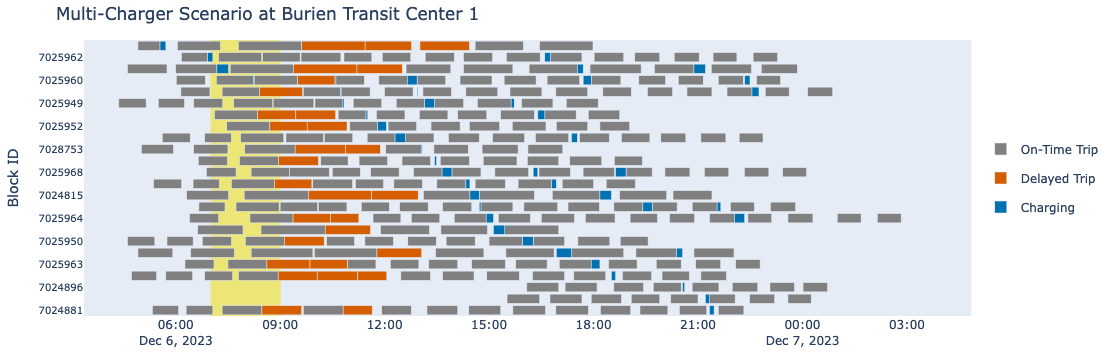

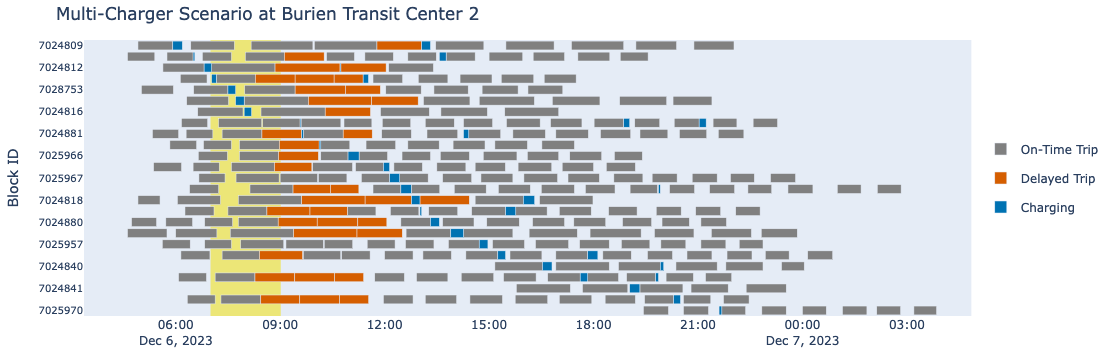

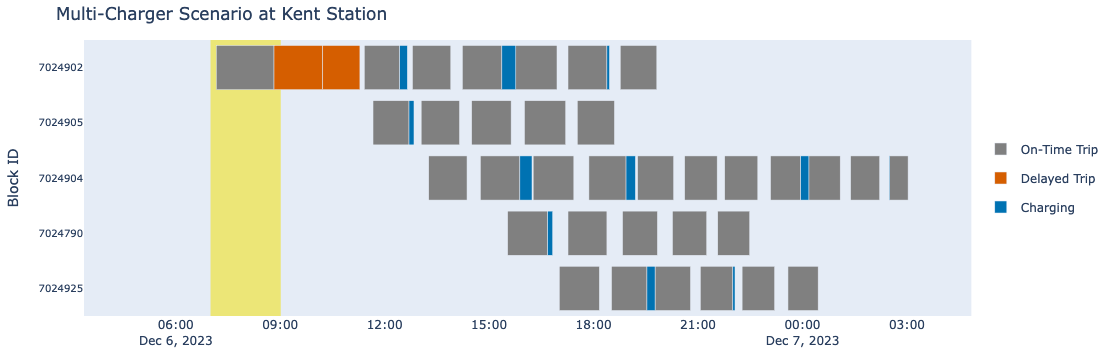

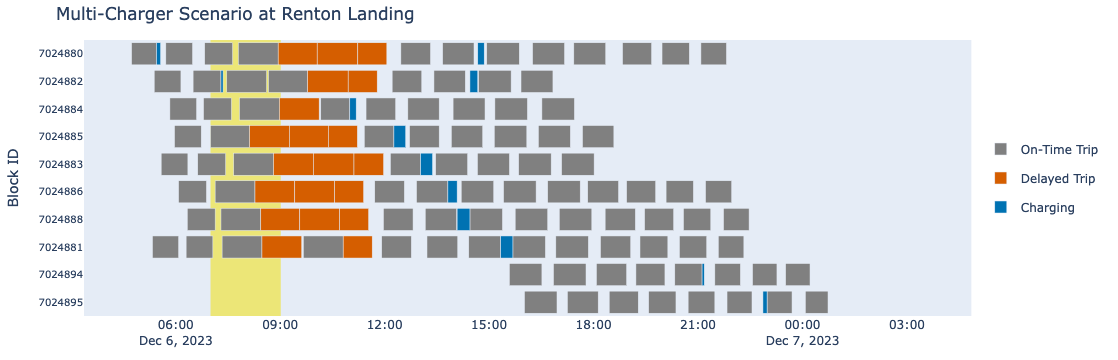

In [20]:
plot_charger_timelines(df, zt, True, True, 'Multi-Charger Scenario at {}')

# Comparison with original solution

In [21]:
orig_df = pd.read_csv(
    '../beb_chargers/tre_original_soln.csv',
    dtype={'block_id': str}
)

In [29]:
df_merge = df[['block_id', 'trip_idx', 'start_time', 'end_time', 'delay']].drop_duplicates()
orig_merge = orig_df[['block_id', 'trip_idx', 'start_time', 'end_time', 'delay']].drop_duplicates()
comp_df = df_merge.merge(orig_merge, on=['block_id', 'trip_idx'])

In [34]:
df[df['block_id'] == '7024809']

,block_id,trip_idx,charger,soc,start_time,end_time,plugin_time,chg_time,delay,Delayed,trip_name
20,7024809,0,Burien Transit Center 1,300.000000,295.0,355.0,355.000000,0.000000,0.0,On-Time Trip,"Block 7024809, Trip 0"
21,7024809,0,Burien Transit Center 2,300.000000,295.0,355.0,355.000000,16.416512,0.0,On-Time Trip,"Block 7024809, Trip 0"
22,7024809,0,Kent Station,300.000000,295.0,355.0,355.000000,0.000000,0.0,On-Time Trip,"Block 7024809, Trip 0"
23,7024809,0,Renton Landing,300.000000,295.0,355.0,355.000000,0.000000,0.0,On-Time Trip,"Block 7024809, Trip 0"
24,7024809,1,Burien Transit Center 1,300.000000,386.0,461.0,490.000000,0.000000,0.0,On-Time Trip,"Block 7024809, Trip 1"
25,7024809,1,Burien Transit Center 2,300.000000,386.0,461.0,490.000000,0.000000,0.0,On-Time Trip,"Block 7024809, Trip 1"
26,7024809,1,Kent Station,300.000000,386.0,461.0,490.000000,0.000000,0.0,On-Time Trip,"Block 7024809, Trip 1"
27,7024809,1,Renton Landing,300.000000,386.0,461.0,490.000000,0.000000,0.0,On-Time Trip,"Block 7024809, Trip 1"
28,7024809,2,Burien Transit Center 1,230.907474,490.0,596.4,599.000000,0.000000,0.0,On-Time Trip,"Block 7024809, Trip 2"
29,7024809,2,Burien Transit Center 2,230.907474,490.0,596.4,599.000000,0.000000,0.0,On-Time Trip,"Block 7024809, Trip 2"


In [33]:
comp_df[(comp_df['end_time_x'] != comp_df['end_time_y'])]

,block_id,trip_idx,start_time_x,end_time_x,delay_x,start_time_y,end_time_y,delay_y
8,7024809,3,599.0,706.8,0.0,599.0,676.0,0.0
18,7024810,3,549.0,658.2,14.2,549.0,627.0,14.2
34,7024815,2,577.0,686.2,11.6,577.0,655.0,11.6
50,7024818,3,568.0,677.2,9.2,568.0,646.0,9.2
71,7024880,5,598.0,668.0,5.8,598.0,648.0,5.8
85,7024881,4,580.0,648.6,0.0,580.0,629.0,0.0
100,7024882,4,583.0,653.0,4.2,583.0,633.0,4.2
110,7024883,4,595.0,665.0,2.2,595.0,645.0,2.2
130,7024885,3,550.0,617.2,5.8,550.0,598.0,5.8
141,7024886,3,553.0,621.6,12.2,553.0,602.0,12.2


In [25]:
df['delay'].sum()

1237.009396133391

In [22]:
orig_df[orig

,block_id,trip_idx,charger,soc,start_time,end_time,plugin_time,chg_time,delay
0,7024790,0,Burien Transit Center,300.000000,932.0,1001.0,1001.000000,0.000000,0.0
1,7024790,0,Kent Station,300.000000,932.0,1001.0,1001.000000,8.554144,0.0
2,7024790,0,Renton Landing,300.000000,932.0,1001.0,1001.000000,0.000000,0.0
3,7024790,1,Burien Transit Center,275.667529,1036.0,1103.0,1130.000000,0.000000,0.0
4,7024790,1,Kent Station,275.667529,1036.0,1103.0,1130.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...
1333,7028753,7,Kent Station,104.626243,888.0,950.0,960.365393,0.000000,0.0
1334,7028753,7,Renton Landing,104.626243,888.0,950.0,960.365393,0.000000,0.0
1335,7028753,8,Burien Transit Center,67.463743,967.0,1027.0,1027.000000,0.000000,0.0
1336,7028753,8,Kent Station,67.463743,967.0,1027.0,1027.000000,0.000000,0.0


# Scenario A Results

In [4]:
zt = datetime.datetime(2023, 12, 6, 0, 0)
a_df = pd.read_csv('scenario_a_soln.csv')
a_df['block_id'] = a_df['block_id'].astype(str)

FileNotFoundError: [Errno 2] No such file or directory: 'scenario_a_soln.csv'

## Charger Timelines

In [ ]:
plot_charger_timelines(a_df, zt, True, True, 'Scenario A at {}')

## Hourly Charging

In [ ]:
a_by_hr = get_charging_by_hour(a_df, zt)
a_by_hr = a_by_hr.reset_index()
px.bar(a_by_hr, x='hour', y='chg_time', color='charger', barmode='stack')

# Scenario B Results

## Charger Timelines

In [ ]:
b_df

In [ ]:
b_df = pd.read_csv('scenario_b_soln.csv')
b_df['block_id'] = b_df['block_id'].astype(str)
plot_charger_timelines(b_df, zt, True, True, 'Scenario B at {}')

## Hourly Charging

In [ ]:
hr_df = get_charging_by_hour(b_df, zt)
chg_by_hr = hr_df.reset_index()
px.bar(chg_by_hr, x='hour', y='chg_time', color='charger', barmode='stack')

# Hourly Charging Comparison

In [ ]:
a_total = a_by_hr.groupby('hour').sum()
a_total['Scenario'] = 'A'
b_total = chg_by_hr.groupby('hour').sum()
b_total['Scenario'] = 'B'

In [ ]:
mixed_df = pd.concat([a_total.reset_index(drop=False), b_total.reset_index(drop=False)])

In [ ]:
px.ecdf(mixed_df, x='hour', y='chg_time', color='Scenario', ecdfnorm=None)

In [ ]:
fig = px.bar(
    mixed_df, x='hour', y='chg_time',
    color='Scenario',
    color_discrete_map={'A': 'rgb(230,159,0)', 'B': 'rgb(0,114,178)'},
    barmode='group',
    labels={'chg_time': 'Total Charging Time (min.)', 'hour': 'Hour'})
fig.update_layout(legend=dict(
            yanchor="middle",
            y=0.5,
            xanchor="left",
            x=1.02
        ))

config = {
    'toImageButtonOptions': {
        'format': 'png',
        'scale': 3
    }
}
fig.show(config=config)

In [ ]:
n_chgs_a = len(a_df[a_df['chg_time'] > 0])
n_blocks = a_df['block_id'].nunique()
print(n_chgs_a, n_blocks, n_chgs_a / n_blocks)

In [ ]:
n_chgs_b = len(heur_df[heur_df['chg_time'] > 0])
n_blocks = heur_df['block_id'].nunique()
print(n_chgs_b, n_blocks, n_chgs_b / n_blocks)

# Simple Case Results

In [ ]:
zt = datetime.datetime(2023, 12, 6, 7, 0)
simple_df = pd.read_csv('simple_case_400kW.csv')
simple_df['block_id'] = simple_df['block_id'].astype(str)

In [ ]:
plot_charger_timelines(simple_df, zt, True, False, '{}: 400 kW')

In [ ]:
simple_df[simple_df['delay'] > 0]

In [ ]:
'Block ' + simple_df['block_id'].astype(str) + ', Trip ' + simple_df['trip_idx'].astype(str)